In [1]:
import numpy as np
import tensorflow as tf
import pylab as plt
import cmocean
from scipy.spatial import cKDTree

/home/josh/anaconda3/envs/kerastf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def generate_data_aliased(noise=0.,sample=100):
    """Generate Gaussian bump in phase.
    noise : float
        amount of gaussian noise to add as fraction of peak height
    sample : int
        number to sample
    """
    #max gradient at b
    a = 50
    b = 1
    max_slope = np.abs(a/np.sqrt(np.exp(1))/b)
    
    #in dx want max_slope*dx > np.pi
    dx = 1.1*np.pi/max_slope
    
    N = 10
    xvec = np.linspace(-dx*N, dx*N, N*2 + 1)
    X,Y = np.meshgrid(xvec,xvec,indexing='ij')
    phi = a * np.exp(-(X**2 + Y**2)/2./b**2)
    X = np.array([X.flatten(),Y.flatten()]).T
    
    phi += a*noise*np.random.normal(size=phi.shape)
    phi = phi.flatten()
    if sample != 0:
        mask = np.random.choice(phi.size,size=min(sample,phi.size),replace=False)
        return X[mask,:],phi[mask]
    return X,phi

def generate_data_nonaliased(noise=0.,sample=100):
    """Generate Gaussian bump in phase.
    noise : float
        amount of gaussian noise to add as fraction of peak height
    sample : int
        number to sample
    """
    #max gradient at b
    a = 15
    b = 1
    max_slope = np.abs(a/np.sqrt(np.exp(1))/b)
    
    #in dx want max_slope*dx < np.pi
    dx = 0.5*np.pi/max_slope
    
    N = 10
    xvec = np.linspace(-dx*N, dx*N, N*2 + 1)
    X,Y = np.meshgrid(xvec,xvec,indexing='ij')
    phi = a * np.exp(-(X**2 + Y**2)/2./b**2)
    X = np.array([X.flatten(),Y.flatten()]).T
    
    phi += a*noise*np.random.normal(size=phi.shape)
    phi = phi.flatten()
    if sample != 0:
        mask = np.random.choice(phi.size,size=min(sample,phi.size),replace=False)
        return X[mask,:],phi[mask]
    return X,phi

def generate_data_nonaliased_nonsquare(noise=0.,sample=100):
    """Generate Gaussian bump in phase.
    noise : float
        amount of gaussian noise to add as fraction of peak height
    sample : int
        number to sample
    """
    #max gradient at b
    a = 20
    b = 1
    max_slope = np.abs(a/np.sqrt(np.exp(1))/b)
    
    #in dx want max_slope*dx = np.pi (nyquist limit)
    dx = np.pi/max_slope/2.
    
    #dx = sqrt(D^2/samples)
    assert sample > 0
    D = np.sqrt(dx**2*sample)
    
    X = np.random.uniform(low=-D/2.,high=D/2.,size=(sample,2))
    
    phi = a * np.exp(-(X[:,0]**2 + X[:,1]**2)/2./b**2)
    
    phi += a*noise*np.random.normal(size=phi.shape)

    return X,phi

def plot_phase(X,phi,label=None,figname=None):
    """Plot the phase.
    X : array (num_points, 2)
        The coords
    phi : array (num_points,)
        The phases
    """
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:,0],X[:,1],phi,c=np.angle(np.exp(1j*phi)),cmap=cmocean.cm.phase,s=10,vmin=-np.pi,vmax=np.pi,label=label or "")
    plt.colorbar(sc)
    if label is not None:
        plt.legend(frameon=False)
    if figname is not None:
        plt.savefig(figname)
    plt.show()
    
    

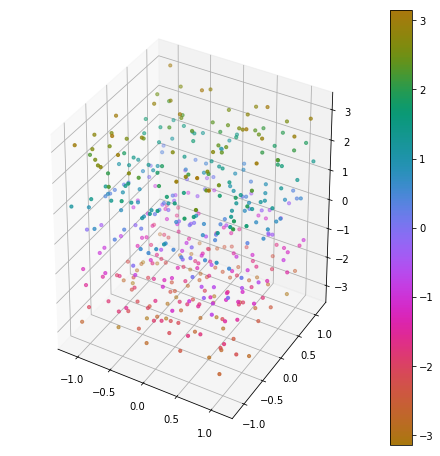

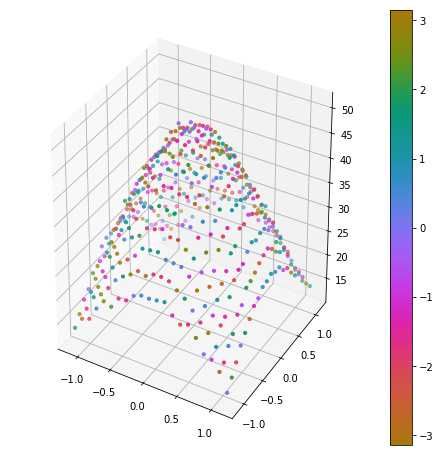

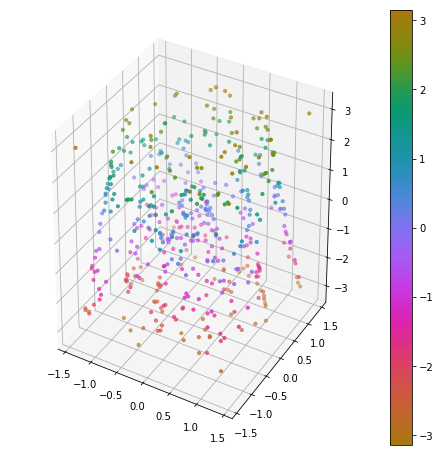

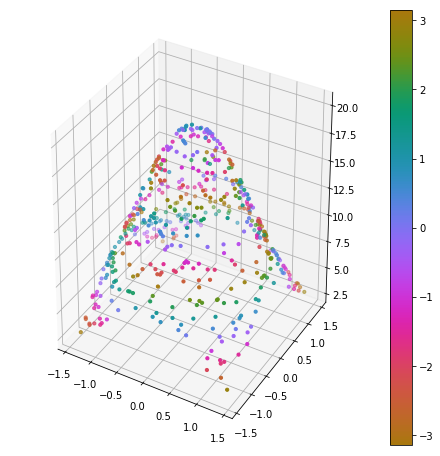

In [3]:
X,phi = generate_data_aliased(0.01,sample=0)
plot_phase(X,np.angle(np.exp(1j*phi)))
plot_phase(X,phi)

X,phi = generate_data_nonaliased_nonsquare(0.0,sample=500)
plot_phase(X,np.angle(np.exp(1j*phi)))
plot_phase(X,phi)

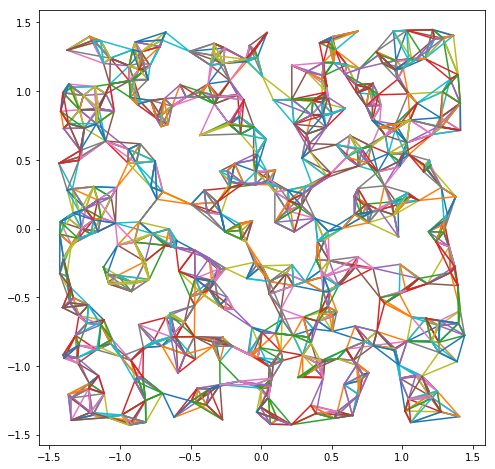

In [4]:
def create_triplets(X,redundancy=2):
    kt = cKDTree(X)
    #get center of map
    C = np.mean(X,axis=0)
    _,idx0 = kt.query(C,k=1)
    idx0 = np.random.randint(X.shape[0])
    #define unique path
    dist, idx = kt.query(X[idx0,:],k=2)
    path = [(idx0, idx[1])]
    included = [idx0, idx[1]]
    while len(included) < X.shape[0]:
        dist,idx = kt.query(X[included,:],k = len(included)+1)
        mask = np.where(np.isin(idx,included,invert=True))
        argmin = np.argmin(dist[mask])
        idx_from = included[mask[0][argmin]]
        idx_to = idx[mask[0][argmin]][mask[1][argmin]]
        path.append((idx_from,idx_to))
        included.append(idx_to)

    M = np.mean(X[path,:],axis=1)
    _,idx = kt.query(M,k=2 + redundancy)
    triplets = []
    for i,p in enumerate(path):
        count = 0
        for c in range(2 + redundancy):
            if idx[i][c] not in p:
                triplets.append(p + (idx[i][c],))
                count += 1
                if count == redundancy:
                    break
    triplets = np.sort(triplets,axis=1)
    triplets = np.unique(triplets,axis=0)
    return path,triplets

fig = plt.figure(figsize=(8,8))

for i,j,k in create_triplets(X,redundancy=4)[1]:
    plt.plot([X[i,0],X[j,0],X[k,0],X[i,0]],[X[i,1],X[j,1],X[k,1],X[i,1]])
    

#plt.savefig('residue_triplets_3_redundant.png')
plt.show()
    

# dist,idx = kt.query(X,k=4)
# triplets = np.sort(idx[:,[0,2,3]],axis=1)
# ra = np.ravel_multi_index((triplets[:,0],triplets[:,1],triplets[:,2]),[X.shape[0]]*3)
# unique_triplets = np.unique(ra)
# triplets = np.stack(np.unravel_index(unique_triplets,[X.shape[0]]*3),axis=1)
# print(triplets)
    
# M = (X[triplets[:,0],:] + X[triplets[:,1],:] + X[triplets[:,2],:])/3.
# kt = cKDTree(M)
# _,idx = kt.query(M[0,:],k = M.shape[0])
# print(idx)

# # trips_ = []
# # for n in range(len(idx)-1):
# #     trips_.append((triplets[idx[n],0],triplets[idx[n],1], triplets[idx[n+1],2]))
# # triplets = np.concatenate([triplets,trips_],axis=0)
# # triplets = np.unique(triplets,axis=0)
# print(triplets)
# for i,j,k in triplets:
#     plt.plot([X[i,0],X[j,0],X[k,0],X[i,0]],[X[i,1],X[j,1],X[k,1],X[i,1]])
# #plt.plot(M[idx,0],M[idx,1],c='red')
# plt.show()



In [236]:
()

()

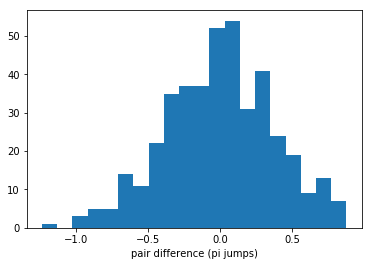

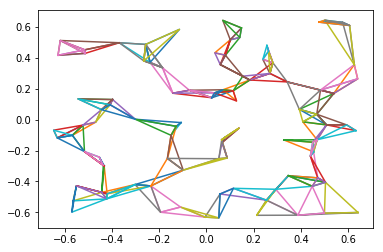

Epoch : 0 loss=3.0675 | LSE: 0.6788 | Residue: 0.1915 | Entropy: 2.1972 | TV: 0.0000 
Epoch : 4739 loss=0.5492 | LSE: 0.1369 | Residue: 0.1277 | Entropy: 0.2832 | TV: 0.0014 
Epoch : 9386 loss=0.1474 | LSE: 0.0014 | Residue: -0.0000 | Entropy: 0.1454 | TV: 0.0005 
Epoch : 10513 loss=0.0995 | LSE: 0.0015 | Residue: -0.0000 | Entropy: 0.0979 | TV: 0.0001 
Epoch : 10513 loss=0.0995 | LSE: 0.0015 | Residue: -0.0000 | Entropy: 0.0979 | TV: 0.0001 


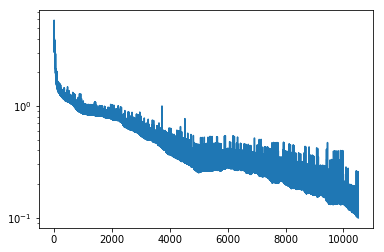

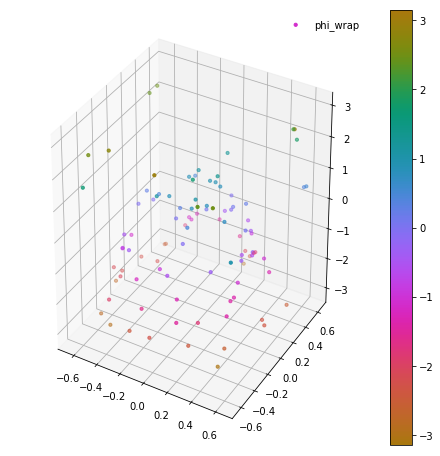

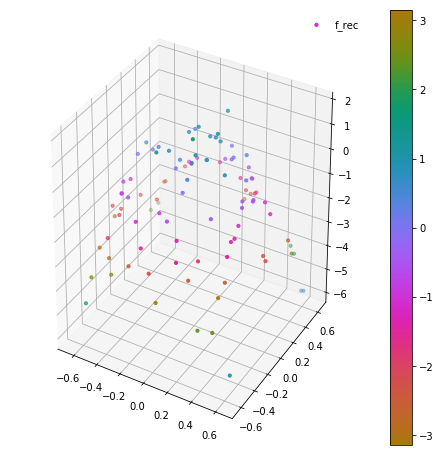

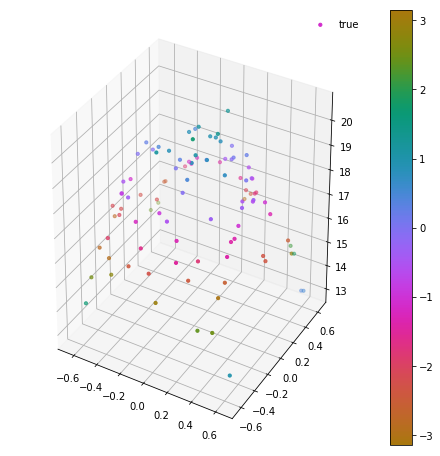

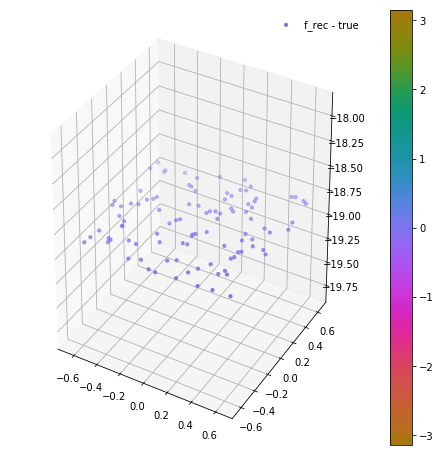

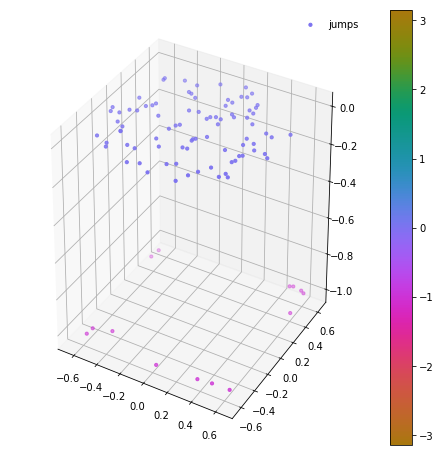

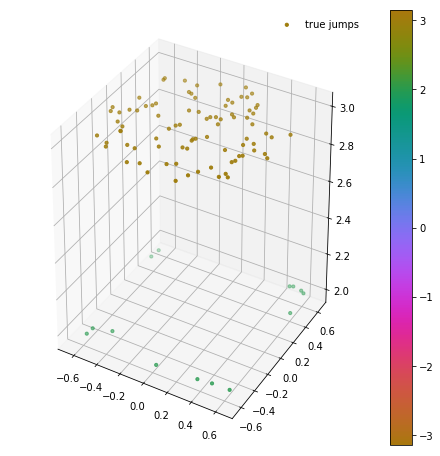

In [5]:




def phase_unwrap(X,phi_wrap,phi_wrap_var=None,redundancy=2,dropout=0.5):
    if len(phi_wrap.shape) == 1:
        phi_wrap = phi_wrap[None,None,:,None]
    Na,Nt,Nd,Nf = phi_wrap.shape
    path_, triplets_ = create_triplets(X,redundancy=redundancy)
    pairs = np.unique(np.sort(np.concatenate([triplets_[:,[0,1]],triplets_[:,[1,2]],triplets_[:,[2,0]]],axis=0),axis=1),axis=0)
    N = pairs.shape[0]

    g = tf.Graph()
    sess = tf.InteractiveSession(graph=g)
    with g.as_default():
        with tf.name_scope("unwrapper") as scope:
            g = tf.placeholder(tf.float32,shape=(Na,Nt,Nd,Nf),name='g')
            triplets = tf.placeholder(tf.int32,shape=(len(triplets_),3),name='triplets')
            path = tf.placeholder(tf.int32,shape=(len(path_),2),name='path')

            def _init(shape,dtype=tf.float64,partition_info=None):
                init = np.zeros(shape)
                #init[:,shape[1]>>1] = np.log(2)
                #init = tf.zeros(shape,dtype=dtype)
                #init[:,shape[1]>>1] = 1.
                return init
            
            K_ = tf.placeholder(tf.float32, shape=(Na,Nt,Nd,Nf,9))

            K = tf.get_variable("K",initializer=K_)
            K_softmax = tf.nn.softmax(K,dim=-1)        

            indices = tf.constant((np.arange(9)-4.).reshape((1,1,1,1,-1)),dtype=tf.float32)
    #         print(indices)
            K_int = tf.reduce_sum(K_softmax*indices,axis=-1)*2*np.pi
    #         print(K_int,triplets)

            #entropy
            entropy = - tf.reduce_mean(tf.reduce_sum(K_softmax*tf.log(K_softmax),axis=-1))

            def _wrap(a):
                return tf.cast(tf.angle(tf.exp(1j*tf.cast(a,tf.complex64))),tf.float32)


            f_noise = tf.get_variable("f_noise",shape=(Na,Nt,Nd,Nf),dtype=tf.float32,initializer=_init)
            #f ~ N(f_obs,sigma_f^2)
            #f(K) = g_i + K 2pi
            # f(K) = int_p dg(x) + 2pi K(x)
            # K ~ N(0,C_K(x,x'))
            # K = K(theta) ~ P(K,  theta) = softmax(theta)
            # log P(K,theta) = sum softmax(theta)_i log(softmax(theta)_i)
            # Hamiltonian: 
            # H(K) =
            K_int_cum = tf.cumsum(K_int,axis=1)
            f = g + K_int_cum + f_noise
            #sigma_f = tf.get_variable("sigma_f",shape=(),dtype=tf.float32,initializer=tf.zeros_initializer)
            #prior for noise gaussian N(0,sigma_f^2)

            #df2 = tf.gather(f,path[:,1]) - tf.gather(f,path[:,0])
            #loss_path = tf.square(f[0] - g[0]) + tf.reduce_mean()
            
            dropout_ = tf.placeholder(tf.float32,shape=())
            
            phi_wrap_var_ = tf.placeholder(tf.float32,shape=phi_wrap.shape)

            df = tf.gather(f,pairs[:,1],axis=2) - tf.gather(f,pairs[:,0],axis=2)#tf.get_variable("df",shape=(N,),dtype=tf.float32,initializer=tf.zeros_initializer)
            consistency = tf.sqrt(1.+tf.square(_wrap(tf.gather(g,pairs[:,1],axis=2) - tf.gather(g,pairs[:,0],axis=2)) - df)) - 1.
            consistency = tf.nn.dropout(consistency,dropout_)
            loss_lse = tf.reduce_mean(consistency)
            #cov = tf.expand_dims(f_noise,-1)
            #loss_tv = tf.reduce_mean(tf.reduce_mean(tf.abs(cov*tf.transpose(cov,perm=[1,0])),axis=1),axis=0)
            loss_tv = tf.reduce_mean(tf.square(f_noise)/phi_wrap_var_)
            
#             smooth_residuals = tf.sqrt(1.+tf.square(tf.gather(f_noise,pairs[:,1],axis=1) - tf.gather(f_noise,pairs[:,0],axis=1))) - 1.
#             #smooth_residuals = tf.nn.dropout(smooth_residuals,dropout_)
#             loss_smooth = tf.reduce_mean(smooth_residuals)
#             #loss_tv += tf.reduce_mean(tf.square(tf.gather(K_int,pairs[:,1]) - tf.gather(K_int,pairs[:,0])))
            
            #loss_tv = tf.reduce_mean(tf.square(f_noise))
            #length_scale = np.mean(np.abs(X[pairs[:,1],:] - X[pairs[:,0],:]))
            #kernel = (0.1**2)*tf.cast(tf.exp(-pdist(tf.constant(X[None,:,:]))/2./(length_scale)**2),tf.float32)
            #loss_reg = tf.reduce_mean(tf.matmul(tf.expand_dims(K_int,0),tf.linalg.triangular_solve(kernel[0,:,:],tf.expand_dims(K_int,-1)))/2.)
            #tf.reduce_mean(tf.square(tf.gather(K_int,pairs[:,1]) - tf.gather(K_int,pairs[:,0])))

    #         mean,var = tf.nn.moments(df,axes=[0])
    #         loss_lse += var

            Wf = _wrap(f)

            df01 = tf.gather(Wf,triplets[:,1],axis=2) - tf.gather(Wf,triplets[:,0],axis=2)
            df01 = _wrap(df01) 
            df12 = tf.gather(Wf,triplets[:,2],axis=2) - tf.gather(Wf,triplets[:,1],axis=2)
            df12 = _wrap(df12)
            df20 = tf.gather(Wf,triplets[:,0],axis=2) - tf.gather(Wf,triplets[:,2],axis=2)
            df20 = _wrap(df20)

            residue = tf.sqrt(1. + tf.square(df01 + df12 + df20))-1.
            residue = tf.nn.dropout(residue,dropout_)
            loss_residue = tf.reduce_mean(residue)

            #K_int_mean = (tf.gather(K_int,triplets[:,0]) + tf.gather(K_int,triplets[:,1]) + tf.gather(K_int,triplets[:,2]))/3.
            #loss_reg = tf.reduce_mean(1./(1+0)*tf.abs(tf.gather(K_int,triplets[:,0]) - K_int_mean) + tf.abs(tf.gather(K_int,triplets[:,1]) - K_int_mean) + tf.abs(tf.gather(K_int,triplets[:,2]) - K_int_mean))
            #loss_reg = tf.reduce_mean(tf.sqrt(1.+tf.square(tf.gather(K_int,pairs[:,1]) - tf.gather(K_int,pairs[:,0]))))
            
            learning_rate = tf.placeholder(tf.float32,shape=())
            opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
            entropy_weight = tf.placeholder(tf.float32,shape=())
            train_op = opt.minimize(loss_lse+entropy_weight*entropy+loss_residue+loss_tv)

            losses = [loss_lse ,loss_residue,entropy,loss_tv]

            sess.run(tf.global_variables_initializer(), feed_dict = {K_: np.zeros([Na,Nt,Nd,Nf,9])})
            import time
            time_ = time.mktime(time.gmtime())sess.run(tf.global_variables_initializer(), feed_dict = {K_: np.zeros([Na,Nt,Nd,Nf,9])})
            loss_per_step_ = []
            
            for epoch in range(25000):
                ew = 0.0000001
                lr = 0.1
                dp = 0.2
                if epoch > 1000:
                    ew = 0.000001
                    lr = 0.1
                    dp = 0.3
                if epoch > 5000:
                    ew = 0.00001
                    lr = 0.05
                    dp = 0.3
                if epoch > 10000:
                    ew = 0.001
                    lr = 0.03
                    dp = 0.5
                if epoch > 15000:
                    ew = 0.01
                    lr = 0.01
                    dp = 0.5
                if epoch > 20000:
                    ew = 0.01
                    lr = 0.001
                    dp = 0.8
                
                if phi_wrap_var is None:
                    phi_wrap_var = np.ones_like(phi_wrap)
                
                
                    
                _,losses_,df_,K_int_,K_softmax_,f_noise_ = sess.run([train_op,losses,df,K_int,K_softmax,f_noise],
                                                           feed_dict={dropout_:dp,
                                                                      learning_rate:lr,
                                                                      entropy_weight: ew, 
                                                                      g : phi_wrap, 
                                                                      triplets: triplets_, 
                                                                      path:path_,
                                                                      phi_wrap_var_ : phi_wrap_var})
                loss_per_step_.append(np.sum(losses_))
                        
                if np.sum(losses_) < 0.1:
                    print("Epoch : {} loss={:.4f} | LSE: {:.4f} | Residue: {:.4f} | Entropy: {:.4f} | TV: {:.4f} ".format(epoch,np.sum(losses_),*losses_))
                    break
                if time.mktime(time.gmtime()) - time_ > 5. or epoch==0:
                    time_ = time.mktime(time.gmtime())
                    print("Epoch : {} loss={:.4f} | LSE: {:.4f} | Residue: {:.4f} | Entropy: {:.4f} | TV: {:.4f} ".format(epoch,np.sum(losses_),*losses_))
                    if np.sum(losses_) < 0.1:
                        break
            print("Epoch : {} loss={:.4f} | LSE: {:.4f} | Residue: {:.4f} | Entropy: {:.4f} | TV: {:.4f} ".format(epoch,np.sum(losses_),*losses_))
            f_rec = np.zeros_like(phi_wrap)
            f_rec[:,:,path_[0][0],:] = phi_wrap[:,:,path_[0][0],:]
            K_int_sum_ = np.cumsum((np.argmax(K_softmax_,axis=4)-4)*2*np.pi,axis=1)
            #print(df_)
            for i,p in enumerate(path_):
                df_ = phi_wrap[:,:,p[1],:] - phi_wrap[:,:,p[0],:] + K_int_sum_[:,:,p[1],:] - K_int_sum_[:,:,p[0],:]
                f_rec[:,:,p[1],:] = f_rec[:,:,p[0],:] + df_
            plt.plot(loss_per_step_)
            plt.yscale('log')
            plt.show()
        return f_rec
            
        #df = (np.argmax(K_softmax_,axis=1)-5)*2*np.pi
        #f_rec = phi_wrap + df
        #f_rec = phi_wrap + K_int_
        
X,phi = generate_data_nonaliased_nonsquare(0.03,sample=100)
#X,phi = generate_data_aliased(0.0,sample=0)

path_, triplets_ = create_triplets(X,redundancy=2)
dist = np.concatenate([phi[triplets_[:,1]] - phi[triplets_[:,0]],
                       phi[triplets_[:,2]] - phi[triplets_[:,1]],
                       phi[triplets_[:,0]] - phi[triplets_[:,2]]],axis=0)/np.pi
plt.hist(dist,bins=20)
plt.xlabel("pair difference (pi jumps)")
plt.show()

for i,j,k in triplets_:
    plt.plot([X[i,0],X[j,0],X[k,0],X[i,0]],[X[i,1],X[j,1],X[k,1],X[i,1]])
    
#plt.savefig('residue_triplets_3_redundant.png')
plt.show()

phi_wrap = np.angle(np.exp(1j*phi))
f_rec = phase_unwrap(X,phi_wrap,redundancy=2)[0,0,:,0]


plot_phase(X,phi_wrap,label='phi_wrap',figname='phi_wrap.png')
plot_phase(X,f_rec,label='f_rec',figname='phi_rec.png')
plot_phase(X,phi,label='true',figname='phi_true.png')
plot_phase(X,f_rec-phi,label='f_rec - true',figname='rec_true_diff.png')
plot_phase(X,(f_rec-np.angle(np.exp(1j*f_rec)))/(2*np.pi),label='jumps',figname='jumps_rec.png')
plot_phase(X,(phi-phi_wrap)/(2*np.pi),label='true jumps',figname='jumps_true.png')

In [11]:
from ionotomo import *
datapack = DataPack(filename='rvw_datapack.hdf5')

In [6]:
ant_idx=-1
time_idx=-1
dir_idx=-1
freq_idx=range(0,125,5)
directions, patch_names = datapack.get_directions(dir_idx=dir_idx)
antennas, antenna_labels = datapack.get_antennas(ant_idx=ant_idx)
times,timestamps = datapack.get_times(time_idx=time_idx)
freqs = datapack.get_freqs(freq_idx=freq_idx)
Na = len(antennas)
Nt = len(times)
Nd = len(directions)
Nf = len(freqs)
fixtime = times[0]
fixfreq = freqs[Nf>>1]
phase_center = datapack.get_center_direction()
array_center = datapack.radio_array.get_center()
uvw = [Pointing(location = array_center.earth_location,obstime = times[j],fixtime=fixtime, phase = phase_center) for j in range(1)]
ants_uvw = [antennas.transform_to(uvw[j]) for j in range(1)]
dirs_uvw = [directions.transform_to(uvw[j]) for j in range(1)]



NameError: name 'datapack' is not defined

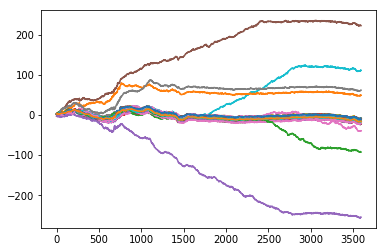

In [13]:
phase=np.angle(np.exp(1j*datapack.get_phase(ant_idx=ant_idx,time_idx=time_idx,dir_idx=dir_idx,freq_idx=freq_idx)))
#plt.plot(phase[0,:,:,0])
from rathings.phase_unwrap import phase_unwrapp1d
phase = np.transpose(phase_unwrapp1d(np.transpose(phase,axes=[1,0,2,3]),axis=0),axes=[1,0,2,3])
phase = np.transpose(phase_unwrapp1d(np.transpose(phase,axes=[3,1,2,0]),axis=0),axes=[3,1,2,0])
plt.plot(phase[51,:,:,0])
plt.show()
phi = phase[:,:,:,:]
phi_wrap=phi
X = np.array([dirs_uvw[0].u.value,dirs_uvw[0].v.value]).T

In [21]:
phase_rec = []
print(X.shape)
for i in range(62):
    f_rec = phase_unwrap(X,phase[i:i+1,:,:,:],redundancy=2)
    phase_rec.append(f_rec)
phase_rec = np.concatenate(phase_rec,axis=0)



# plot_phase(X,phi_wrap,label='phi_wrap',figname='phi_wrap.png')
# plot_phase(X,f_rec,label='f_rec',figname='phi_rec.png')
# plot_phase(X,phi,label='true',figname='phi_true.png')
# plot_phase(X,f_rec-phi,label='f_rec - true',figname='rec_true_diff.png')
# plot_phase(X,(f_rec-np.angle(np.exp(1j*f_rec)))/(2*np.pi),label='jumps',figname='jumps_rec.png')
# plot_phase(X,(phi-phi_wrap)/(2*np.pi),label='true jumps',figname='jumps_true.png')





(100, 2)


InvalidArgumentError: indices[1] = 71 is not in [0, 42)
	 [[Node: unwrapper/GatherV2_2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT64, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_unwrapper/g_0_4, unwrapper/GatherV2_2/indices, unwrapper/GatherV2_2/axis)]]

Caused by op 'unwrapper/GatherV2_2', defined at:
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-b1265b7457c9>", line 4, in <module>
    f_rec = phase_unwrap(X,phase[i:i+1,:,:,:],redundancy=2)
  File "<ipython-input-16-f57cbe5f6b62>", line 67, in phase_unwrap
    consistency = tf.sqrt(1.+tf.square(_wrap(tf.gather(g,pairs[:,1],axis=2) - tf.gather(g,pairs[:,0],axis=2)) - df)) - 1.
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2488, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2035, in gather_v2
    "GatherV2", params=params, indices=indices, axis=axis, name=name)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[1] = 71 is not in [0, 42)
	 [[Node: unwrapper/GatherV2_2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT64, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_unwrapper/g_0_4, unwrapper/GatherV2_2/indices, unwrapper/GatherV2_2/axis)]]


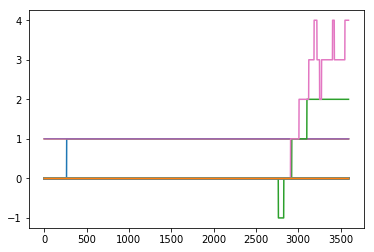

In [147]:
#f_rec = phase_unwrapp1d(f_rec,axis=0)
jumps = (f_rec-phi_wrap)/(2*np.pi)

#phase[0,:,:,0] += jumps[None,:]
[plt.plot(range(3595),jumps[:,i]) for i in range(42)]
plt.show()


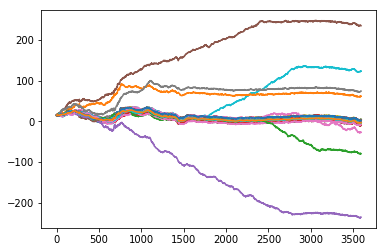

In [27]:
phase = np.transpose(phase_unwrapp1d(np.transpose(phase,axes=[1,0,2,3]),axis=0),axes=[1,0,2,3])
plt.plot(phase[0,:,:,0])
plt.show()

In [63]:
import time

1510832122.0

In [7]:
import gpflow as gp

In [11]:
K = gp.kernels.RBF(2,lengthscales=[1.],variance=1.)
m = gp.models.GPR(X,phi[:,None],kern=K)

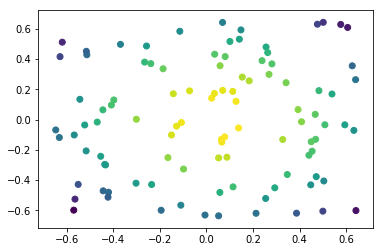

In [22]:
plt.scatter(X[:,0],X[:,1],c=m.predict_f_samples(X,1).flatten())
plt.show()

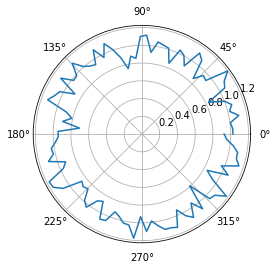

In [13]:
import numpy as np
import pylab as plt
x = 0.1*np.random.normal(size=100)+1
plt.polar(np.linspace(0,np.pi*2,100),x)
plt.show()